# 06 - Feature Engineering + Random Forest

**Approach 5**: Feature engineering and conventional machine learning.

This notebook extracts meaningful features from LinkedIn CV data and trains a Random Forest classifier.

## Key Features:
- **Career features**: Number of previous jobs, total experience, average tenure
- **Keyword features**: Bilingual EN/DE seniority and department indicators
- Combined with TF-IDF for text representation

## Setup

In [19]:
import sys
sys.path.insert(0, '..')

import json
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from src.data.loader import load_linkedin_data, prepare_dataset
from src.models.feature_ml import (
    FeatureEngineer, FeatureEngineerConfig,
    CombinedFeatureClassifier
)

DATA_DIR = Path('../data')
MODELS_DIR = Path('../models')
RANDOM_STATE = 42

print("Setup complete!")

Setup complete!


## 1. Load Data

In [20]:
# Load annotated CVs
cvs_annotated = load_linkedin_data(DATA_DIR / 'linkedin-cvs-annotated.json')
print(f"Loaded {len(cvs_annotated)} annotated CVs")

# Prepare dataset with text representation
df = prepare_dataset(cvs_annotated, include_history=True)
print(f"Dataset shape: {df.shape}")
df.head()

Loaded 609 annotated CVs
Dataset shape: (478, 7)


,cv_id,title,company,text,department,seniority,history
0,0,Prokurist,Depot4Design GmbH,Prokurist at Depot4Design GmbH,Other,Management,Buchhalterin
1,1,Solutions Architect,Computer Solutions,Solutions Architect at Computer Solutions,Information Technology,Professional,Senior Network Engineer | Manager of Network S...
2,2,Medizintechnik Beratung,Udo Weber,Medizintechnik Beratung at Udo Weber,Consulting,Professional,Projektleiter Medizintechnik | Nationaler Acco...
3,3,Director expansión de negocio.,Grupo Viajes Kontiki.,Director expansión de negocio. at Grupo Viajes...,Business Development,Director,Gerente general comercial | Director Desarroll...
4,4,"APL-ansvarig, samordning",Himmelstalunds Utbildningscentrum,"APL-ansvarig, samordning at Himmelstalunds Utb...",Administrative,Lead,Utbildningsledare inom Servicekunskap och Förs...


In [21]:
# Check label distributions
print("Department distribution:")
print(df['department'].value_counts())
print(f"\nSeniority distribution:")
print(df['seniority'].value_counts())

Department distribution:


department
Other                     250
Information Technology     55
Sales                      37
Project Management         31
Consulting                 28
Marketing                  18
Business Development       17
Human Resources            15
Purchasing                 12
Administrative              9
Customer Support            6
Name: count, dtype: int64

Seniority distribution:
seniority
Professional    161
Management      138
Lead            103
Senior           39
Director         27
Junior           10
Name: count, dtype: int64


## 2. Feature Engineering Exploration

Let's explore the features we can extract from the CV data.

In [22]:
# Extract features using our FeatureEngineer
feature_engineer = FeatureEngineer()
features_df = feature_engineer.extract_features(cvs_annotated)

print(f"Extracted {len(features_df.columns)} features from {len(features_df)} CVs:")
print(list(features_df.columns))
features_df.head(10)

Extracted 17 features from 478 CVs:
['num_previous_jobs', 'total_experience_months', 'avg_tenure_months', 'num_companies', 'has_senior_keyword', 'has_management_keyword', 'has_entry_keyword', 'has_information_technology_keyword', 'has_human_resources_keyword', 'has_finance_keyword', 'has_sales_keyword', 'has_marketing_keyword', 'has_operations_keyword', 'has_legal_keyword', 'title_length', 'title_word_count', 'title_has_numbers']


,num_previous_jobs,total_experience_months,avg_tenure_months,num_companies,has_senior_keyword,has_management_keyword,has_entry_keyword,has_information_technology_keyword,has_human_resources_keyword,has_finance_keyword,has_sales_keyword,has_marketing_keyword,has_operations_keyword,has_legal_keyword,title_length,title_word_count,title_has_numbers
0,1,308,103.000000,2,0,1,0,0,0,0,0,0,0,0,9,1,0
1,7,279,34.875000,5,0,0,0,1,0,0,0,0,0,0,19,2,0
2,2,465,154.333333,3,0,0,0,1,0,0,0,0,0,0,23,2,0
3,4,181,73.428571,7,0,1,0,0,0,0,0,0,0,0,30,4,0
4,7,77,77.000000,7,0,0,0,0,0,0,0,0,0,0,24,2,0
5,1,340,170.000000,2,1,0,0,0,0,0,0,0,0,0,21,2,0
6,0,0,0.000000,1,0,0,0,0,0,0,0,0,0,0,14,1,0
7,6,203,25.428571,4,0,0,0,0,1,0,0,0,0,0,26,3,0
8,4,235,55.500000,5,0,1,0,0,0,0,0,0,0,0,17,2,0
9,0,312,312.000000,5,0,0,0,0,0,0,0,0,0,0,12,2,0


In [23]:
# Feature statistics
print("Feature Statistics:")
features_df.describe()

Feature Statistics:


,num_previous_jobs,total_experience_months,avg_tenure_months,num_companies,has_senior_keyword,has_management_keyword,has_entry_keyword,has_information_technology_keyword,has_human_resources_keyword,has_finance_keyword,has_sales_keyword,has_marketing_keyword,has_operations_keyword,has_legal_keyword,title_length,title_word_count,title_has_numbers
count,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000
mean,3.761506,248.052301,95.374021,3.803347,0.175732,0.481172,0.023013,0.135983,0.027197,0.046025,0.083682,0.027197,0.035565,0.010460,26.274059,3.219665,0.014644
std,3.367377,133.477687,101.871684,2.797691,0.380991,0.500169,0.150100,0.343130,0.162826,0.209759,0.277200,0.162826,0.185397,0.101846,16.621391,2.284730,0.120250
min,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,1.000000,0.000000
25%,1.000000,155.000000,32.833333,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15.000000,2.000000,0.000000
50%,3.000000,244.000000,57.675000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22.000000,3.000000,0.000000
75%,6.000000,337.250000,118.812500,5.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33.750000,4.000000,0.000000
max,27.000000,654.000000,510.000000,29.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,99.000000,15.000000,1.000000


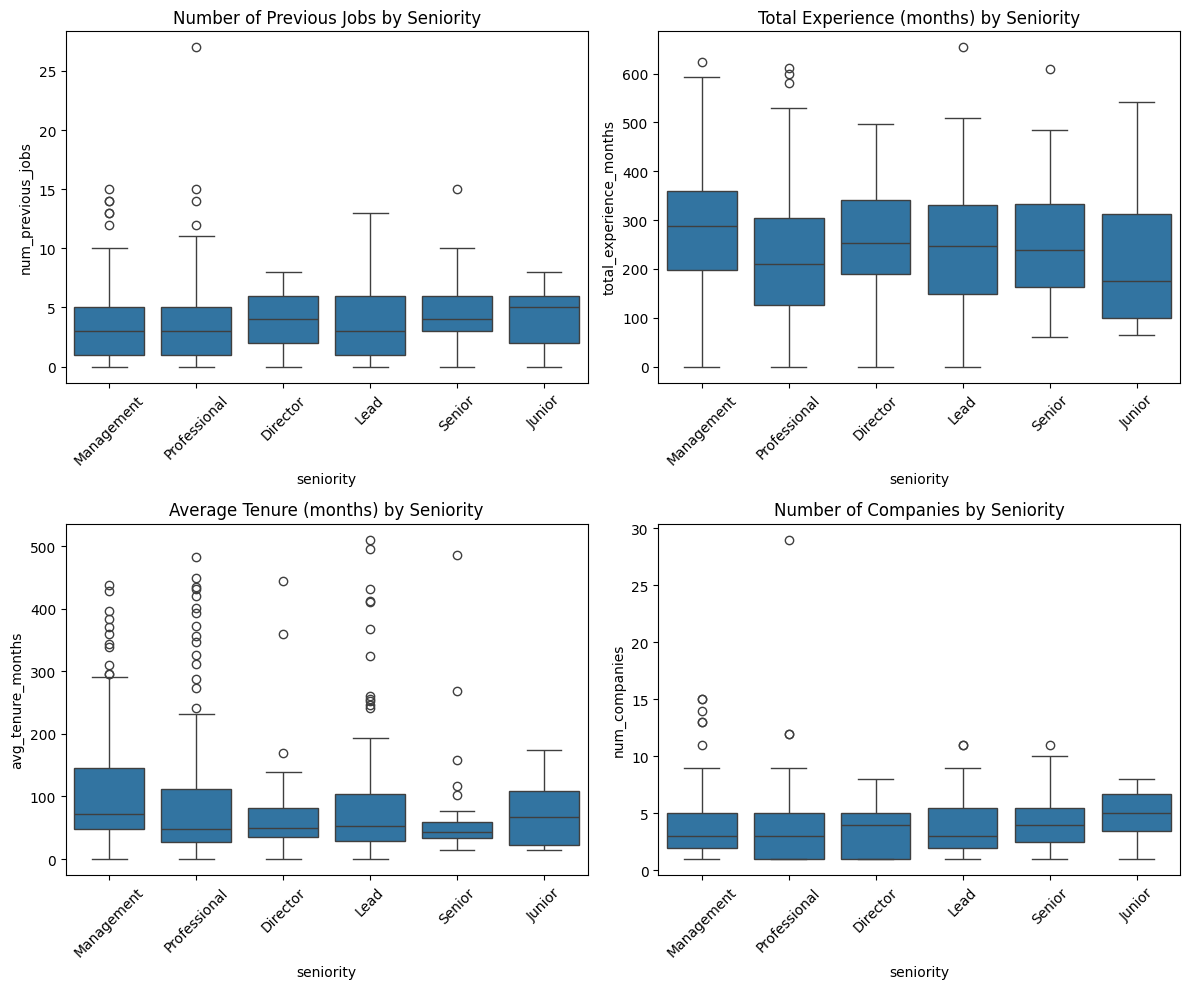

In [24]:
# Visualize career features by seniority
features_with_labels = features_df.copy()
features_with_labels['seniority'] = df['seniority'].values
features_with_labels['department'] = df['department'].values

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Previous jobs by seniority
sns.boxplot(data=features_with_labels, x='seniority', y='num_previous_jobs', ax=axes[0, 0])
axes[0, 0].set_title('Number of Previous Jobs by Seniority')
axes[0, 0].tick_params(axis='x', rotation=45)

# Experience by seniority
sns.boxplot(data=features_with_labels, x='seniority', y='total_experience_months', ax=axes[0, 1])
axes[0, 1].set_title('Total Experience (months) by Seniority')
axes[0, 1].tick_params(axis='x', rotation=45)

# Tenure by seniority
sns.boxplot(data=features_with_labels, x='seniority', y='avg_tenure_months', ax=axes[1, 0])
axes[1, 0].set_title('Average Tenure (months) by Seniority')
axes[1, 0].tick_params(axis='x', rotation=45)

# Companies by seniority
sns.boxplot(data=features_with_labels, x='seniority', y='num_companies', ax=axes[1, 1])
axes[1, 1].set_title('Number of Companies by Seniority')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('results/06_career_features_by_seniority.png', dpi=150, bbox_inches='tight')
plt.show()

In [25]:
# Keyword feature effectiveness
keyword_cols = [c for c in features_df.columns if 'keyword' in c]
print("Keyword feature detection rates:")
for col in keyword_cols:
    rate = features_df[col].mean() * 100
    print(f"  {col}: {rate:.1f}%")

Keyword feature detection rates:
  has_senior_keyword: 17.6%
  has_management_keyword: 48.1%
  has_entry_keyword: 2.3%
  has_information_technology_keyword: 13.6%
  has_human_resources_keyword: 2.7%
  has_finance_keyword: 4.6%
  has_sales_keyword: 8.4%
  has_marketing_keyword: 2.7%
  has_operations_keyword: 3.6%
  has_legal_keyword: 1.0%


## 3. Train/Test Split

In [26]:
# Create indices for train/test split
indices = np.arange(len(df))

train_idx, test_idx = train_test_split(
    indices, 
    test_size=0.2, 
    random_state=RANDOM_STATE,
    stratify=df['department']
)

print(f"Train size: {len(train_idx)}")
print(f"Test size: {len(test_idx)}")

# Prepare data splits
train_texts = df.iloc[train_idx]['text'].tolist()
test_texts = df.iloc[test_idx]['text'].tolist()

train_dept = df.iloc[train_idx]['department'].tolist()
test_dept = df.iloc[test_idx]['department'].tolist()

train_seniority = df.iloc[train_idx]['seniority'].tolist()
test_seniority = df.iloc[test_idx]['seniority'].tolist()

# Raw CVs for feature engineering (use cv_id to get correct mapping)
# Note: df indices don't match cvs_annotated indices since CVs without active positions are filtered out
train_cv_ids = df.iloc[train_idx]['cv_id'].tolist()
test_cv_ids = df.iloc[test_idx]['cv_id'].tolist()
train_cvs = [cvs_annotated[i] for i in train_cv_ids]
test_cvs = [cvs_annotated[i] for i in test_cv_ids]

Train size: 382
Test size: 96


## 4. Train Combined Features + Random Forest

In [27]:
# Train Combined Feature + Random Forest classifiers
dept_combined = CombinedFeatureClassifier(classifier_type='random_forest')
dept_combined.fit(train_texts, train_cvs, train_dept)

seniority_combined = CombinedFeatureClassifier(classifier_type='random_forest')
seniority_combined.fit(train_texts, train_cvs, train_seniority)

print("Combined Features + Random Forest models trained!")

Combined Features + Random Forest models trained!


## 5. Evaluation

In [28]:
# Evaluate
dept_pred = dept_combined.predict(test_texts, test_cvs)
seniority_pred = seniority_combined.predict(test_texts, test_cvs)

print("=" * 60)
print("COMBINED FEATURES + RANDOM FOREST RESULTS")
print("=" * 60)

print("\n--- Department Classification ---")
print(f"Accuracy: {accuracy_score(test_dept, dept_pred):.4f}")
print("\nClassification Report:")
print(classification_report(test_dept, dept_pred))

print("\n--- Seniority Classification ---")
print(f"Accuracy: {accuracy_score(test_seniority, seniority_pred):.4f}")
print("\nClassification Report:")
print(classification_report(test_seniority, seniority_pred))

COMBINED FEATURES + RANDOM FOREST RESULTS

--- Department Classification ---
Accuracy: 0.6458

Classification Report:
                        precision    recall  f1-score   support

        Administrative       0.00      0.00      0.00         2
  Business Development       0.50      0.33      0.40         3
            Consulting       1.00      0.50      0.67         6
      Customer Support       0.00      0.00      0.00         1
       Human Resources       0.00      0.00      0.00         3
Information Technology       0.62      0.45      0.53        11
             Marketing       0.50      0.25      0.33         4
                 Other       0.64      0.94      0.76        50
    Project Management       0.00      0.00      0.00         6
            Purchasing       1.00      0.50      0.67         2
                 Sales       0.67      0.50      0.57         8

              accuracy                           0.65        96
             macro avg       0.45      0.32     

c:\Users\julie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\julie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\julie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

## 6. Feature Importance Analysis

In [29]:
# Feature importances for Random Forest
print("Top 20 features for DEPARTMENT:")
dept_importance = dept_combined.get_feature_importances(top_n=20)
dept_importance

Top 20 features for DEPARTMENT:


,feature,importance
0,total_experience_months,0.053824
1,title_length,0.049523
2,avg_tenure_months,0.048121
3,num_previous_jobs,0.039383
4,has_sales_keyword,0.034169
5,num_companies,0.031988
6,title_word_count,0.029315
7,has_information_technology_keyword,0.025892
8,consultant,0.022181
9,has_human_resources_keyword,0.020119


In [30]:
print("Top 20 features for SENIORITY:")
seniority_importance = seniority_combined.get_feature_importances(top_n=20)
seniority_importance

Top 20 features for SENIORITY:


,feature,importance
0,director,0.067032
1,has_senior_keyword,0.066522
2,senior,0.065223
3,total_experience_months,0.050267
4,title_length,0.045299
5,avg_tenure_months,0.044677
6,num_previous_jobs,0.036347
7,has_management_keyword,0.034028
8,title_word_count,0.033383
9,has_entry_keyword,0.030730


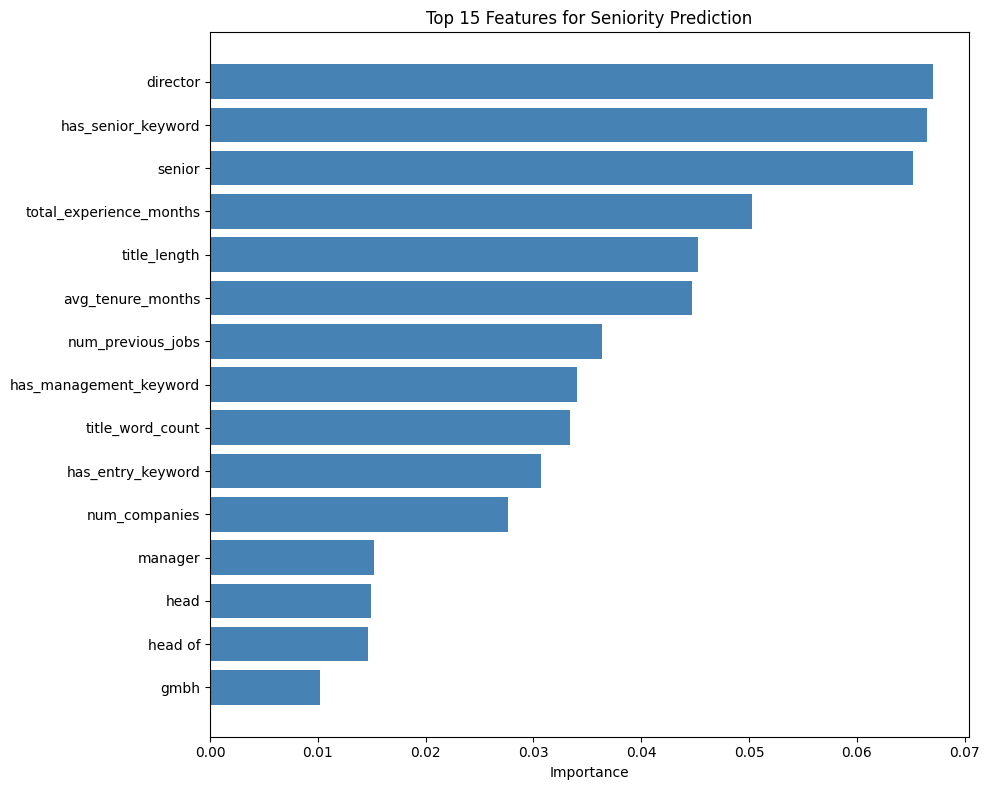

In [31]:
# Visualize feature importance for seniority (most interesting for career features)
fig, ax = plt.subplots(figsize=(10, 8))
top_features = seniority_importance.head(15)
ax.barh(top_features['feature'], top_features['importance'], color='steelblue')
ax.set_xlabel('Importance')
ax.set_title('Top 15 Features for Seniority Prediction')
ax.invert_yaxis()
plt.tight_layout()
plt.savefig('results/06_seniority_feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Confusion Matrices

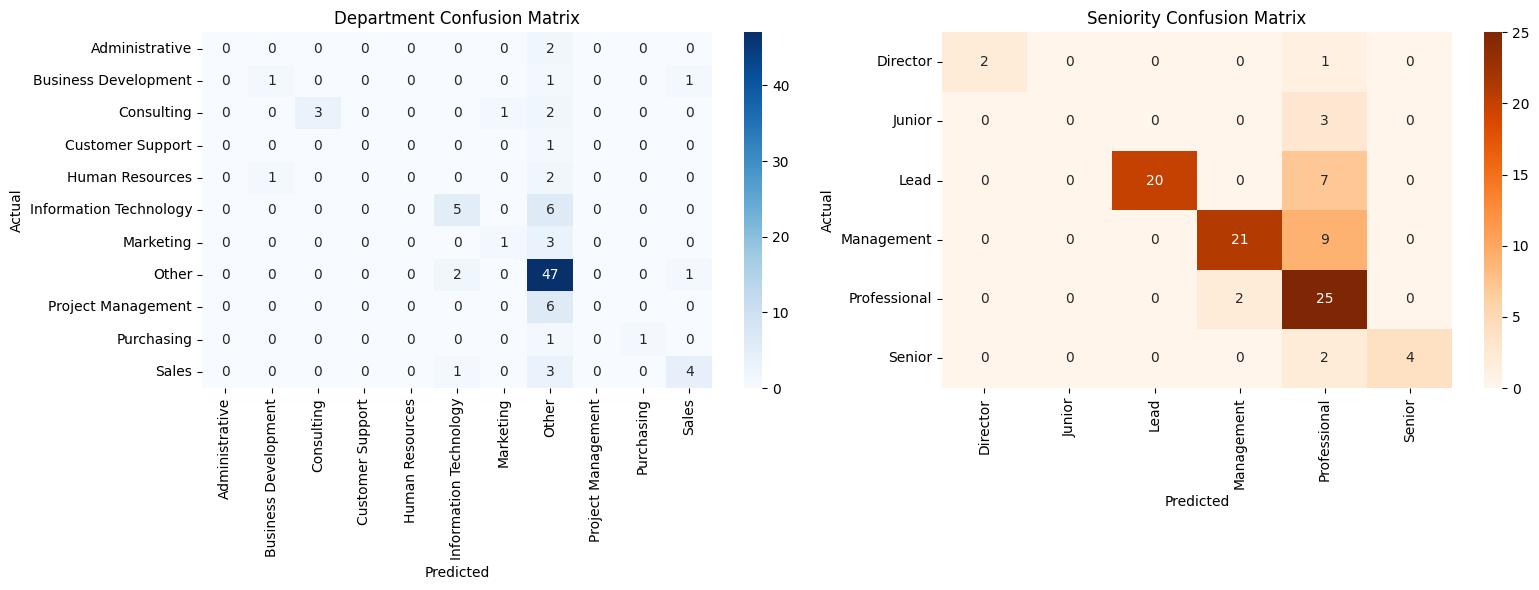

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Department confusion matrix
cm_dept = confusion_matrix(test_dept, dept_pred, labels=sorted(set(test_dept)))
sns.heatmap(cm_dept, annot=True, fmt='d', cmap='Blues', 
            xticklabels=sorted(set(test_dept)), 
            yticklabels=sorted(set(test_dept)), ax=axes[0])
axes[0].set_title('Department Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Seniority confusion matrix
cm_seniority = confusion_matrix(test_seniority, seniority_pred, labels=sorted(set(test_seniority)))
sns.heatmap(cm_seniority, annot=True, fmt='d', cmap='Oranges',
            xticklabels=sorted(set(test_seniority)),
            yticklabels=sorted(set(test_seniority)), ax=axes[1])
axes[1].set_title('Seniority Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.savefig('results/06_confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Save Models

In [33]:
MODELS_DIR.mkdir(exist_ok=True)

dept_combined.save(MODELS_DIR / 'combined_rf_department.pkl')
seniority_combined.save(MODELS_DIR / 'combined_rf_seniority.pkl')

print("Models saved!")

Models saved!


## Summary

This notebook implemented **Approach 5: Feature Engineering + Random Forest**.

### Key Findings:
- Career features (`num_previous_jobs`, `total_experience_months`) are strong seniority indicators
- Bilingual keyword detection (EN/DE) captures title patterns
- Combined TF-IDF + structured features provides rich representation